In [28]:
################################
####### Creating workers #######
################################
using Distributed
n_workers = 10
nprocs()==1 || rmprocs(workers()); addprocs(n_workers, exeflags="--project");

In [29]:
################################
#### Activating the project ####
################################
# @everywhere using Pkg
# @everywhere Pkg.instantiate();
# @everywhere Pkg.activate("../DistributedOptimization");
include("./src/DistributedOptimization.jl")

async_optimize (generic function with 1 method)

### Experiment setting

In [3]:
################################
###### Problem parameters ######
################################

using DistributedArrays
@everywhere using Random
@everywhere Random.seed!(42)

n = 1000
m = 20
λ = 0.01
zero_columns = 0

# active=0 returns 1
# active=1 Returns vector of ones with zeros at the ith block of size nworkers()
# active=2 Returns vector of zeros with ones at the ith block of size nworkers()
@everywhere function zeros_at(i,active=0)
    active==0 && return 1
    to_zero = [(i-1)*(m÷nworkers()) + k for k in 1:m÷nworkers()]
    active==1 && return [all(j .!= to_zero) for j in 1:m]
    active==2 && return [any(j .== to_zero) for j in 1:m]
end
    
A = [@spawnat worker rand(n÷nworkers(),m).*zeros_at(i,zero_columns)' for (i, worker) in enumerate(workers())]
A = reshape(A, :, 1)
A = DArray(A);

x_gen = rand(m,1)

b = [@spawnat worker A.localpart*x_gen + 0.01*rand(Poisson(1),(n÷nworkers(),1)) for worker in workers()]
b = reshape(b, :, 1)
b = DArray(b);

objective = Objective(A,b,λ);

In [4]:
################################
###### Learning parameters #####
################################
epochs = 0
time = 300
slow_workers = Dict(zip(workers()[1:2], [5,10]));
# slow_workers = Dict();
γ_paper = 0.99/objective.L
γ_piag  = 0.99/objective.L

9.89534891261379e-5

### Experiment

In [5]:
##############################################################
################## Enforcing JIT compilation #################
##############################################################
async_optimize(rand(m,1), PaperSolver(objective, 0.1), epochs=2);
async_optimize(rand(m,1), PiagSolver(objective, 0.1), epochs=2);
sync_optimize(rand(m,1), PaperSolver(objective, 0.1), epochs=2);

In [6]:
##############################################################
####################### Finding x_star #######################
##############################################################
paper_solver = PaperSolver(objective, 0.99/objective.L)
history_sync_paper = sync_optimize(rand(m,1), paper_solver; epochs=10000, verbose=1000);
x_star = history_sync_paper.logs["x"][end];
norm(x_star-x_gen)

epoch=1, elapsed=0.0
epoch=1000, elapsed=3.755735958
epoch=2000, elapsed=7.383090416
epoch=3000, elapsed=10.889166375
epoch=4000, elapsed=14.367895125
epoch=5000, elapsed=17.912540416
epoch=6000, elapsed=21.443635333
epoch=7000, elapsed=24.936538083
epoch=8000, elapsed=28.427613875
epoch=9000, elapsed=31.90054025
epoch=10000, elapsed=35.393021833


0.2986587774837032

### Chosing γ

In [7]:
###############################################################
############## Experiment for different γs ####################
###############################################################

gamma_histories = Dict("piag" =>Dict{Float64,History}([]), 
                       "paper"=>Dict{Float64,History}([]),
                       "sync" =>Dict{Float64,History}([]))

x_init = rand(m,1)
time = 100

print("◀︎")
for γ in 10. .^ (-3:0.5:3) ./ objective.L
    
    ########################### PAPER ###########################
    paper_solver = PaperSolver(objective, γ); # initializes worker_solver
    history = async_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    gamma_histories["paper"][γ*objective.L] = history
    print("■")
    
end
print("▶︎")


print("◀︎")
for γ in 10. .^ (-3:0.5:3) ./ objective.L

    ############################ PIAG #############################
    piag_solver = PiagSolver(objective, γ); # initializes worker_solver
    history = async_optimize(x_init, piag_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    gamma_histories["piag"][γ*objective.L] = history
    print("■")
    
end
print("▶︎")


print("◀︎")
for γ in 10. .^ (-3:0.5:3) ./ objective.L

    ############################# SYNC ############################
    paper_solver = PaperSolver(objective, γ);
    history = sync_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    gamma_histories["sync"][γ*objective.L] = history
    print("■")
    
end
print("▶︎")

println("◇")

◀︎■■■■■■▶︎◀︎■■■■■▶︎◀︎■■■■■■▶︎◇


In [8]:
###############################################################
##################### Establishing best γs ####################
###############################################################

h(x)  = x⋅log.(x)
∇h(x) = log.(x) .+ 1
D = (x,y) -> h(x) - h(y) - ∇h(y)⋅(x-y)

mins = Dict("paper"=>[100.,0],"piag"=>[100.,0], "sync"=>[100.,0])

for (algo_name, algo_dict) in gamma_histories
    for (gamma, history) in algo_dict
        tmp = D(x_gen,history.logs["x"][end])
        if tmp < mins[algo_name][1]
            mins[algo_name][1] = tmp            
            mins[algo_name][2] = gamma
        end
    end
end

In [9]:
γ_paper = mins["paper"][2] / objective.L
γ_piag  = mins["piag"][2]  / objective.L
γ_sync  = mins["sync"][2]  / objective.L

0.01999060386386624

In [10]:
###############################################################
######################### Experiment ##########################
###############################################################

histories = Dict{String, Vector{History}}("piag"=>[], "paper"=>[], "sync"=>[], "piag_best"=>[], "paper_best"=>[], "sync_best"=>[])
time = 300

for k in 1:2
    print("◀︎"); x_init = rand(m,1)
    
    ############################# SYNC ############################
    paper_solver = PaperSolver(objective, 0.9/objective.L); # initializes worker_solver
    history = sync_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["sync"],[history])
    print("■")
    paper_solver = PaperSolver(objective, γ_paper); # initializes worker_solver
    history = sync_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["sync_best"],[history])
    print("■")
    
    ########################### PAPER ###########################
    paper_solver = PaperSolver(objective, 0.9/objective.L); # initializes worker_solver
    history = async_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["paper"],[history])
    print("■")
    paper_solver = PaperSolver(objective, γ_paper); # initializes worker_solver
    history = async_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["paper_best"],[history])
    print("■")
    
    ############################ PIAG #############################
    piag_solver = PiagSolver(objective, 0.9/objective.L); # initializes worker_solver
    history = async_optimize(x_init, piag_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["piag"],[history])
    print("■")
    piag_solver = PiagSolver(objective, γ_piag); # initializes worker_solver
    history = async_optimize(x_init, piag_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["piag_best"],[history])
    print("■")
    
    print("▶︎")
end
println("◇")

◀︎■■■■■■▶︎◀︎■■■■■■▶︎◇


### Saving & Loading experiment data

In [11]:
###############################################################
########################### Saving ############################
###############################################################

using JLD2, FileIO

file_name = "histories_10"

isdir("./data") || mkdir("./data");
parameters = Dict("n"=>n,"m"=>m,"λ"=>λ,"zero_columns"=>zero_columns, "epochs"=>epochs, "x_gen"=>x_gen,
                  "time"=>time, "slow_workers"=>slow_workers)
save("./data/$file_name.jld2", "parameters", parameters, "histories", histories, "gamma_histories", gamma_histories)

-- *Load from here* --

In [35]:
# #############################################################
# ######################## Loading ############################
# #############################################################

# include("./src/DistributedOptimization.jl")
# using JLD2, FileIO

# file_name = "histories_10"
# loaded_data       = load("./data/$file_name.jld2")
# parameters        = loaded_data["parameters"];
# histories         = loaded_data["histories"]
# gamma_histories   = loaded_data["gamma_histories"]

# ######## Assigning dictionary values to variables ############
# for (key, value) in parameters
#     @eval ($(Symbol(key)) = $value)
# end

### Plots

In [20]:
###############################################################
########################### Plots #############################
###############################################################

using Plots
using PlotlyJS
using PGFPlotsX
using LaTeXStrings

function learning_curves(;xlabel, ylabel, yscale, histories, to_plot, objective=objective, file_name="", save_as="", x_star=nothing, ribbon=false)

    save_as in ["tex", "pdf", "tikz"] ? pgfplotsx() : gr()
    
    plt = Plots.plot(yscale=yscale, legend=:topright, grid=true)
    
    h(x)  = x⋅log.(x)
    ∇h(x) = log.(x) .+ 1
    
    ylabel=="norm"        && (D = (x,y) -> norm(x-y,2); ylabel!(L"||x^*-x^k||_2"))
    ylabel=="bregman"     && (D = (x,y) -> h(x) - h(y) - ∇h(y)⋅(x-y); ylabel!(L"D_h(x^*,x^k)"))
    ylabel=="objective"   && ylabel!(L"f(x^k)+g(x^k)")
    ylabel=="∇objective"  && ylabel!(L"||∇f(x^k)+∇g(x^k)||^2")
    
    xlabel=="time"        && xlabel!("Time (s)")
    xlabel=="epochs"      && xlabel!("Epochs")
    xlabel=="iterations"  && xlabel!("Iterations")
    
    isnothing(x_star) && (x_stars = [history.logs["x"][end] for history in histories["sync"]])
    
    for algorithm in to_plot
        
        algo_histories = histories[algorithm]
        
        algorithm == "paper" && (linestyle=:solid; label="Ours"; color=:palegreen2)
        algorithm == "piag" && (linestyle=:solid; label="PIAG"; color=:salmon1)
        algorithm == "sync" && (linestyle=:solid; label="Synchronous"; color=:deepskyblue1)
        algorithm == "paper_best" && (linestyle=:dash; label="Ours (best γ)"; color=:palegreen2)
        algorithm == "piag_best" && (linestyle=:dash; label="PIAG (best γ)"; color=:salmon1)
        algorithm == "sync_best" && (linestyle=:dash; label="Synchronous (best γ)"; color=:deepskyblue1)
        
        X_tmp = []
        Y_tmp = []
        
        end_epoch       = min([history.epoch for history in algo_histories]...)
        end_time        = min([history.logs["elapsed"][end] for history in algo_histories]...)
        end_iteration   = min([length(history.logs["x_iter"]) for history in algo_histories]...)
        
        for (i, history) in enumerate(algo_histories)
            if xlabel=="iterations"
                isnothing(x_star) && (x_star = x_stars[i])
                append!(Y_tmp, [[D(x_star,x) for x in history.logs["x_iter"][1:end_iteration]]])
                
            else
                
                if ylabel=="objective"
                    !haskey(history.logs, "objective") && log!(history, "objective", objective.objective)
                    append!(Y_tmp, [history.logs["objective"][1:end_epoch]])
                elseif ylabel=="∇objective"
                    !haskey(history.logs, "∇objective") && log!(history, "∇objective", objective.∇objective)
                    append!(Y_tmp, [[norm(g,2) for g in history.logs["∇objective"]][1:end_epoch]])
                elseif ylabel in ["norm", "bregman"]
                    isnothing(x_star) && (x_star = x_stars[i])
                    append!(Y_tmp, [[D(x_star,x) for x in history.logs["x"][1:end_epoch]]])
                end
            
                xlabel=="time" && append!(X_tmp, [history.logs["elapsed"][1:end_epoch]])
            end
            
        end
        
        if xlabel=="epochs"
            X = [1:end_epoch]
            Y = mean(Y_tmp)
            V = std(Y_tmp)
        elseif xlabel=="iterations" 
            X = [1:end_iteration]
            Y = mean(Y_tmp)
            V = std(Y_tmp)
        elseif xlabel=="time"
            X = mean(X_tmp)
            Y = mean(Y_tmp)[X .< end_time]
            V = std(Y_tmp)[X .< end_time]
            X = X[X .< end_time]
        end
        
        if !ribbon || (yscale  == :log && any(Y.-V .== 0))
            plot!(X, Y, label=label, linestyle=linestyle, linewidth=2, color=color)
        else
            plot!(X, Y, ribbon=V, fillalpha=.3, label=label, linewidth=2, linestyle=linestyle, color=color)  
        end

    end
    
    isdir("./plots") || mkdir("./plots");
    save_as!="" && Plots.savefig(plt, "./plots/$file_name.$save_as")
    
    gr(); plt
end

learning_curves (generic function with 1 method)

In [100]:
plt = learning_curves(xlabel    = "time", 
                      ylabel    = "bregman",
                      yscale    = :log,
                      histories = histories,
                      to_plot   = ["sync", "piag", "paper", "sync_best", "piag_best", "paper_best"],
                      file_name = file_name,
                      save_as   = "png",
                      x_star    = x_gen,
                      ribbon    = false)

In [94]:
pltA = learning_curves(xlabel   = "iterations", 
                      ylabel    = "bregman",
                      yscale    = :log,
                      histories = histories,
                      to_plot   = ["paper"],
                      x_star    = x_gen,
                      ribbon    = false);

In [93]:
pltB = learning_curves(xlabel   = "iterations", 
                      ylabel    = "norm",
                      yscale    = :log,
                      histories = histories,
                      to_plot   = ["paper"],
                      x_star    = x_gen,
                      ribbon    = false);

In [92]:
pltC = learning_curves(xlabel   = "time", 
                      ylabel    = "bregman",
                      yscale    = :log,
                      histories = histories,
                      to_plot   = ["paper", "sync"],
                      x_star    = x_gen,
                      ribbon    = false);

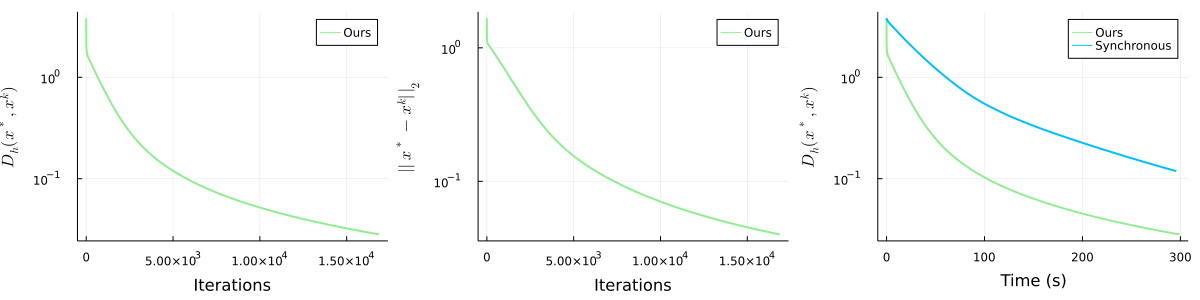

In [99]:
plt = Plots.plot(pltA, pltB, pltC, layout=grid(1,3), size=(1200,300), left_margin = 0.5*Plots.cm, bottom_margin = 0.8*Plots.cm)
Plots.savefig(plt, "./plots/$(file_name)_theorem_illustration.png")
plt